# SQD for ATP

## Setup

In [ ]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [ ]:
ibm_computer: str = "ibm_boston"
qubits = [
    *list(range(69, 73 + 1)),
    78, 79,
    *list(range(83, 95 + 1)),
    96, 97, 98, 99,
    *list(range(103, 115 + 1)),
    117, 118, 119,
    *list(range(124, 135 + 1)),
    137, 138, 139,
    147, 148, 149, 150, 151, 152, 153, 154, 155
]
nshots: int = 100_000

nqubits = len(qubits)
nqubits

64

In [ ]:
# Skip this cell if not running on hardware.
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [ ]:
fragment = "atp_0_be2_f4"

adapt_iterations: int = 1

In [ ]:
circuit_dir =  "circuits"
circuit_fname = f"{fragment}_{adapt_iterations:03d}_adaptiterations.qasm"
circuit_path = f"{circuit_dir}/{fragment}/{circuit_fname}"
circuit_path

'circuits/atp_0_be2_f4/atp_0_be2_f4_001_adaptiterations.qasm'

In [ ]:
circuit = qasm3.load(circuit_path)
circuit.draw(fold=-1, idle_wires=False)

┌───┐ ░  ░ ┌────────┐┌────┐          ┌───┐┌─────────┐                  ┌───┐ ┌────────┐ ┌────┐                                                                                             ┌───┐┌─────────┐    ┌────┐    ┌────────┐                                                          ┌───┐┌──────────┐
 0 ┤ X ├─░──░─┤ Rz(-π) ├┤ √X ├──────────┤ X ├┤ Rz(π/2) ├──────────────────┤ X ├─┤ Rz(-π) ├─┤ √X ├─────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Rz(π/2) ├────┤ √X ├────┤ Rz(-π) ├──────────────────────────────────────────────────────────┤ X ├┤ Rz(-π/2) ├
   ├───┤ ░  ░ └────────┘├───┬┘     ┌───┐└─┬─┘└──┬────┬─┘┌──────────┐┌────┐└─┬─┘┌┴────────┴┐├────┤┌─────────┐     ┌────┐┌────────────┐┌────┐┌────────┐     ┌────┐┌────────────┐┌────┐┌────────┐└─┬─┘└──┬────┬─┘┌───┴────┴───┐└─┬────┬─┘┌────────┐     ┌────┐┌────────────┐┌────┐┌──────────┐     └─┬─┘└──────────┘
 1 ┤ X ├─░──░─────■─────┤ X ├───■──┤ X ├──■─────┤ √X ├──┤ Rz(-π/2) ├┤ √X ├──■──┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├──■──┤ √X ├┤ Rz(3.1804) ├┤ √X ├┤ Rz(3π) ├──■──┤ √X ├┤ Rz(3.1028) ├┤ √X ├┤ Rz(3π) ├──■─────┤ √X ├──┤ Rz(3.1804) ├──┤ √X ├──┤ Rz(3π) ├──■──┤ √X ├┤ Rz(3.1028) ├┤ √X ├┤ Rz(7π/2) ├──■────■──────────────
   └───┘ ░  ░   ┌─┴─┐   └─┬─┘ ┌─┴─┐└───┘        └────┘  └──────────┘└────┘     └──────────┘└────┘└─────────┘┌─┴─┐└────┘└───┬───┬────┘└────┘└────────┘┌─┴─┐└────┘└────────────┘└────┘└────────┘        └────┘  └────────────┘  └────┘  └────────┘┌─┴─┐├───┬┘└────────────┘├───┬┘└──────────┘┌─┴─┐                 
 2 ──────░──░───┤ X ├─────■───┤ X ├──■──────────────────────────────────────────────────────────────────────┤ X ├──■───────┤ X ├───────■─────────────┤ X ├──────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ H ├───────■───────┤ X ├──────■──────┤ X ├──■──────────────
         ░  ░   └───┘         └───┘┌─┴─┐┌───┐                                                               └───┘┌─┴─┐     └─┬─┘     ┌─┴─┐           └───┘                                                                                      └───┘└───┘     ┌─┴─┐     └─┬─┘    ┌─┴─┐    └───┘┌─┴─┐            
 3 ──────░──░──────────────────────┤ X ├┤ H ├────────────────────────────────────────────────────────────────────┤ X ├───────■───────┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────■──────┤ X ├─────────┤ X ├────────────
   ┌───┐ ░  ░                      └───┘└───┘                                                                    └───┘               └───┘                                                                                                                     └───┘              └───┘         └───┘            
 4 ┤ X ├─░──░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   ├───┤ ░  ░                                                                                                                                                                                                                                                                                                    
 5 ┤ X ├─░──░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   ├───┤ ░  ░                                                                                                                                                                                                                                                                                                    
 6 ┤ X ├─░──░────────────

In [ ]:
len(circuit.qubits)

64

In [ ]:
# from qiskit.converters import circuit_to_dag, dag_to_circuit


# dag = circuit_to_dag(circuit)
# print(list(dag.idle_wires()))
# dag.remove_qubits(*list(dag.idle_wires()))
# circuit = dag_to_circuit(dag)

In [ ]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)
base.count_ops()

OrderedDict([('x', 33), ('cx', 19), ('rz', 17), ('sx', 14), ('h', 2)])

## Prepare to run on hardware

In [ ]:
to_run = base.copy()
to_run.measure_all()
to_run = [to_run]

In [ ]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
    seed_transpiler=123
)

In [ ]:
for c in to_run:
    print(c.count_ops())

OrderedDict([('measure', 64), ('sx', 40), ('rz', 33), ('x', 31), ('cz', 19), ('barrier', 1)])


In [ ]:
to_run[0].depth()

55

In [ ]:
ops = list(to_run[0].count_ops().keys())
num = list(to_run[0].count_ops().values())

In [ ]:
sum([number for op, number in to_run[0].count_ops().items() if op != "cz"])

169

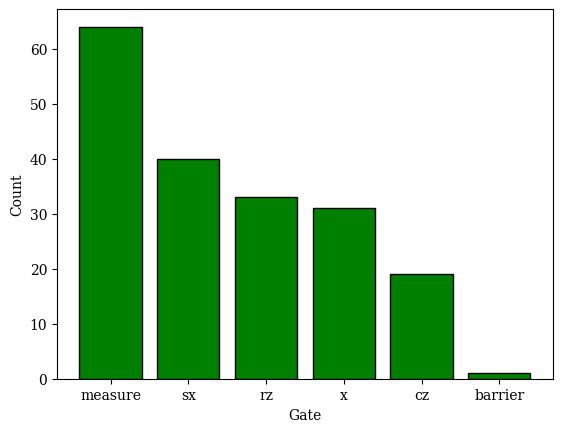

In [ ]:
plt.bar(ops, num, color="green", edgecolor="black")
plt.xlabel("Gate")
plt.ylabel("Count");

In [ ]:
# to_run[0].draw(fold=-1, idle_wires=False)

## Run on exact simulator

In [ ]:
# simulator = AerSimulator(method="matrix_product_state")
# result = simulator.run(to_run, shots=10)
# counts = result.result().get_counts()
# counts

In [ ]:
# hartree_fock_bitstring = list(counts.keys())[0]
# hartree_fock_bitstring

## Run on noisy simulator

In [ ]:
# sim = AerSimulator.from_backend(computer, method="matrix_product_state")

In [ ]:
# result = sim.run(to_run, shots=nshots)
# counts = result.result().get_counts()

In [ ]:
# qiskit.visualization.plot_histogram(
#     counts,
#     target_string=hartree_fock_bitstring,
#     sort="hamming",
#     number_to_keep=10,
#     figsize=(7, 8),
#     title=sim.name,
# )

## Run on hardware

In [ ]:
job = sampler.run(to_run, shots=nshots)
# job = service.job("d5n5uarh36vs73bitksg")

In [ ]:
all_counts_hardware = []

In [ ]:
res = job.result()

In [ ]:
for r in res:
    all_counts_hardware.append(r.data.meas.get_counts())

In [ ]:
len(all_counts_hardware[0])

1926

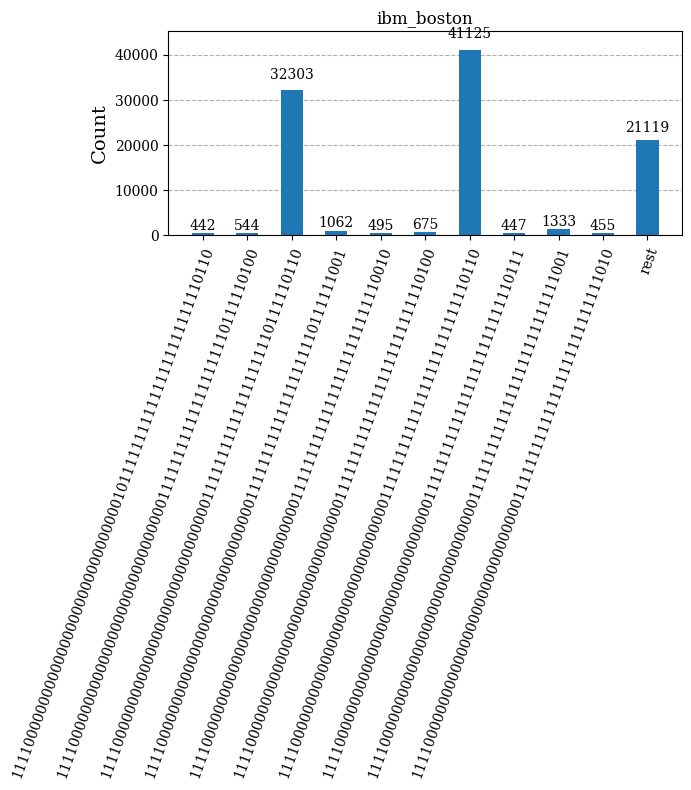

In [ ]:
import qiskit.visualization


qiskit.visualization.plot_histogram(
    all_counts_hardware[0],
    # target_string=hartree_fock_bitstring,
    # sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    title=computer.name,
)

## Save data

In [ ]:
import datetime


time_key = datetime.datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
fname = circuit_fname + f"_counts_{computer.name}_nshots_{nshots}_{time_key}"
fname

'atp_0_be2_f4_001_adaptiterations.qasm_counts_ibm_boston_nshots_100000_2026_02_02_18-29-58'

In [ ]:
pickle.dump(all_counts_hardware[0], open(fname, "wb"))

## Run SQD

In [ ]:
import pyscf.tools
from pyscf import ao2mo

import collections
from functools import partial
import os
import pickle

from qiskit.primitives import BitArray
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

In [ ]:
mode_order = pickle.load(
    open(f"{circuit_dir}/{fragment}/{fragment}_mode_order_{adapt_iterations:03d}_adaptiterations.pkl", "rb")
)
qubit_order = pickle.load(
    open(f"{circuit_dir}/{fragment}/{fragment}_qubit_order_{adapt_iterations:03d}_adaptiterations.pkl", "rb")
)

In [ ]:
hamiltonian_dir = "hamiltonians"

In [ ]:
fcidump = pyscf.tools.fcidump.read(f"{hamiltonian_dir}/{fragment}.fcidump")

Parsing hamiltonians/atp_0_be2_f4.fcidump


In [ ]:
n_orbitals = fcidump.get("NORB")
num_electrons = fcidump.get("NELEC")
ecore = fcidump.get("ECORE")
h1 = fcidump.get("H1")
h2 = fcidump.get("H2")
h2 = ao2mo.restore(1, h2, n_orbitals)

In [ ]:
energy_tol = 1e-8
occupancies_tol = 1e-8
carryover_threshold = 1e-5

In [ ]:
fname = "atp_0_be2_f4_001_adaptiterations.qasm_counts_ibm_boston_nshots_100000_2026_02_02_18-29-58"

In [ ]:
counts = pickle.load(
    open(f"results/{fragment}/{fname}", "rb")
)

In [ ]:
def transform_bitstring(bits):
    """
    Convert a given bitstring from Openfermion convention 
    (alternating alpha/beta, big endian) to Qiskit (all alpha
    then all beta, little endian).
    """

    left = [bits[i] for i in range(len(bits)) if i % 2 == 1]   # beta
    right = [bits[i] for i in range(len(bits)) if i % 2 == 0]  # alpha

    # Reverse each half
    left.reverse()
    right.reverse()

    # Concatenate
    return ''.join(left + right)

In [ ]:
measurement_outcomes = counts
permuted_outcomes = {}
for original_bitstring in measurement_outcomes.keys():
    qubit_permuted_bitstring = "".join([original_bitstring[qubit_order.index(n)] for n in range(nqubits)])
    mode_permuted_bitstring = "".join([qubit_permuted_bitstring[mode_order.index(n)] for n in range(nqubits)])

    final_permuted_bitstring = transform_bitstring(mode_permuted_bitstring)
    permuted_outcomes[final_permuted_bitstring[::]] = measurement_outcomes[original_bitstring]

bit_array = BitArray.from_counts(permuted_outcomes)
counts = bit_array.get_counts()
max_key = max(counts, key=counts.get)
print(f'Most common bitstring: {max_key} with count {counts[max_key]}')
print(f'Total number of bitstrings: {len(counts)}')
print(f"Total number of samples:", sum(counts.values()))

Most common bitstring: 1101001111111111111111111111110000000100101100000000000000000001 with count 41125
Total number of bitstrings: 1926
Total number of samples: 100000


In [ ]:
sci_solver = partial(solve_sci_batch, spin_sq=0, max_cycle=10000)
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + ecore}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    one_body_tensor=h1,
    two_body_tensor=h2,
    bit_array=bit_array,
    samples_per_batch=50_000,
    norb=n_orbitals,
    nelec=(num_electrons // 2, num_electrons // 2),
    num_batches=2,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=100,
    sci_solver=sci_solver,
    symmetrize_spin=True,
    carryover_threshold=carryover_threshold,
    callback=callback,
)

ValueError: The input bit array did not contain any valid bitstrings. Either pass a bit array that contains at least one valid bitstring (with the correct right and left Hamming weights), or specify a value for initial_occupancies.